In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Discussion 4: gradient descent and PyTorch

## Gradient descent algorithm
Gradient descent algorithm is used to minimize a target function. Here, let's look at a very simple case

$$f(x) = x^4 + 3x^3-8x^2$$

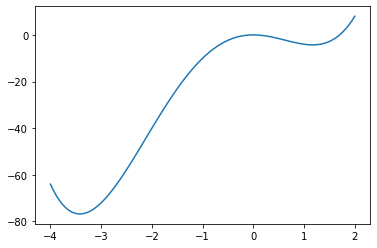

In [3]:
def f(x):
    return x**4 + 3 * x**3 - 8*x**2
xs = np.linspace(-4, 2, 100)
plt.plot(xs, f(xs))

Compute the gradient(derivative) for $f(x)$

$$f'(x) = 4x^3 + 9x^2 - 16x$$

In [5]:
def df(x):
    return 4*x**3 + 9 * x**2 - 16*x

In [34]:
# initial guess
x = 0.5

# learning rate
lr = 0.01

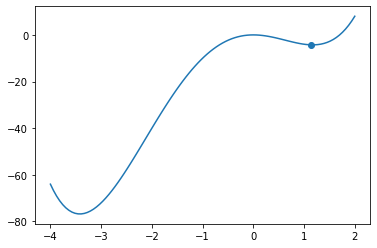

In [53]:
x -= lr * df(x)
plt.plot(xs, f(xs))
plt.scatter([x], [f(x)])

## Gradient descent example: hinge loss linear classifier (soft support vector machine)
We want to train a 2-class linear classifier. When $w^Tx+b$ is positive, we predict class $1$; when $w^Tx+b$ is negative, we predict class $-1$. We let
$$y=w^Tx+b$$
where $x$ is a data point, $w$ and $b$ are trainable weights. Intuitively, when $y$ is a large positive value, we are confident that $x$ belongs to class 1; when $y$ is a large negative value, we are confident that $x$ belongs to class -1.

The loss function we need to minimize is the hinge loss
$$J(y',y) = \max(0, 1-y'y)$$
where $y'\in\{-1, 1\}$ is the ground truth label and $y\in \mathbb R$ is the predicted value.

Intuively, when $y$ is "very right" (it predicts the correct label and it is greater than 1 or less than -1), the loss is $0$. Otherwise we give penalty based on how wrong it is.

Now we have an optimization problem

$$\min_{w,b}\sum_x \max(0, 1-y'(w^Tx+b)) + \frac{1}{2}\lambda w^Tw$$

Let

$$L = \sum_x \max(0, 1-y'(wx+b))$$

and we find its gradient,

$$\frac{\partial L}{\partial w} = \sum_{x, 1-y'(wx+b) > 0} -y'x + \lambda w$$
$$\frac{\partial L}{\partial b} = \sum_{x, 1-y'(wx+b) > 0} -y'$$

In [54]:
from torchvision.datasets import MNIST

In [55]:
train_data = MNIST('.', train=True, download=True)
test_data = MNIST('.', train=False, download=True)

In [56]:
train_X = train_data.data.numpy()
train_y = train_data.targets.numpy()
test_X = test_data.data.numpy()
test_y = test_data.targets.numpy()

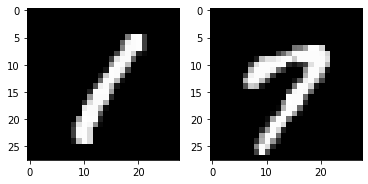

In [57]:
# get 2 classes from cifar
train_X1 = train_X[train_y == 1]
train_X2 = train_X[train_y == 7]
plt.subplot(121)
plt.imshow(train_X1[0], cmap='gray')
plt.subplot(122)
plt.imshow(train_X2[0], cmap='gray')

In [58]:
# get the same 2 classes from the test data
test_X1 = test_X[test_y == 1]
test_X2 = test_X[test_y == 7]

In [59]:
# prepare data and label
train_X = np.concatenate([train_X1, train_X2])
train_features = train_X.reshape([train_X.shape[0], -1])
train_y = np.zeros(train_X.shape[0])
train_y[:train_X1.shape[0]] = 1
train_y[train_X2.shape[0]:] = -1

test_X = np.concatenate([test_X1, test_X2])
test_features = test_X.reshape([test_X.shape[0], -1])
test_y = np.zeros(test_X.shape[0])
test_y[:test_X1.shape[0]] = 1
test_y[test_X2.shape[0]:] = -1

In [60]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from skimage.feature import daisy

In [87]:
from tqdm import tqdm_notebook

In [88]:
w = np.random.randn(train_features.shape[1]) * .5 - .5
b = 0
lr = 0.001
lam = 1

In [89]:
scores = []

In [108]:
idx = np.arange(train_features.shape[0])
np.random.shuffle(idx)
train_features2 = train_features[idx]
train_y2 = train_y[idx]
lr *= 0.95
for x, y in zip(train_features2, train_y2):
    v = lam * w
    if ((w@x)+b) * y < 1:
        w += lr * y * x
        b += lr * y
    w -= lr * v
pred_y = np.sign(test_features @ w + b)
scores.append(accuracy_score(test_y, pred_y))
scores[-1]

0.9204808136846971

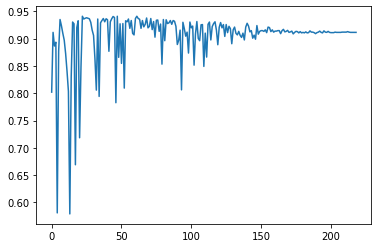

In [113]:
plt.plot(scores)

In [112]:
for _ in tqdm_notebook(range(100)):
    idx = np.arange(train_features.shape[0])
    np.random.shuffle(idx)
    train_features2 = train_features[idx]
    train_y2 = train_y[idx]
    lr *= 0.95
    for x, y in zip(train_features2, train_y2):
        if ((w@x)+b) * y < 1:
            w += lr * y * x
            b += lr * y
    pred_y = np.sign(test_features @ w + b)
    scores.append(accuracy_score(test_y, pred_y))
    scores[-1]

## Introducing PyTorch

In [114]:
import torch
from torch import nn
import torchvision.transforms as transforms

In [115]:
train_dataset = MNIST(root='.', transform=transforms.ToTensor(), train=True, download=True)
test_dataset = MNIST('.', transform=transforms.ToTensor(), train=False)

In [116]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        """init function builds the required layers"""
        super(MLP, self).__init__()  # This line is always required
        # Hidden layer
        self.layer1 = nn.Linear(input_size, hidden_size)
        # activation
        self.relu = nn.ReLU()
        # output layer
        self.layer2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        """forward function describes how input tensor is transformed to output tensor"""
        # flatten the input from (Nx1x28x28) to (Nx784)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        # Note we do not need softmax layer, since this layer is included in the CrossEntropyLoss provided by torch
        return x

In [117]:
model = MLP(784, 1024, 10)
model

MLP(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=1024, out_features=10, bias=True)
)

In [122]:
opts = {
    'lr': 5e-4,
    'epochs': 5,
    'batch_size': 64
}

In [123]:
optimizer = torch.optim.Adam(model.parameters(), opts['lr'])
criterion = torch.nn.CrossEntropyLoss()  # loss function
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=opts['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=opts['batch_size'], shuffle=True)

In [124]:
from tqdm import tqdm_notebook

In [125]:
for epoch in range(opts['epochs']):
    train_loss = []
    for i, (data, labels) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        # reshape data
        data = data.reshape([-1, 784])
        # pass data through network
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  # Important! Otherwise the optimizer will accumulate gradients from previous runs!
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    test_loss = []
    test_accuracy = []
    for i, (data, labels) in enumerate(test_loader):
        # reshape data
        data = data.reshape([-1, 784])
        # pass data through network
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
        test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
    print('epoch: {}, train loss: {}, test loss: {}, test accuracy: {}'.format(epoch, np.mean(train_loss), np.mean(test_loss), np.mean(test_accuracy)))


epoch: 0, train loss: 0.25845983098231273, test loss: 0.13382322538145788, test accuracy: 0.9608877388535032



epoch: 1, train loss: 0.10899110336992532, test loss: 0.09537234421890632, test accuracy: 0.9720342356687898



epoch: 2, train loss: 0.07079220407886673, test loss: 0.08294050286340106, test accuracy: 0.9756170382165605



epoch: 3, train loss: 0.049311918624515914, test loss: 0.07159415142503893, test accuracy: 0.9775079617834395



epoch: 4, train loss: 0.03708762474366025, test loss: 0.06014145113480319, test accuracy: 0.9800955414012739
